In [84]:
import pickle
import re
import string
from multiprocessing import Pool

import contractions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from spellchecker import SpellChecker

In [2]:
columns = ["target", "id", "date", "flag", "user", "text"]
df = pd.read_csv("./input/sentiment140.csv", encoding="ISO-8859-1", names=columns)
df.drop(["id", "date", "flag", "user"], axis="columns", inplace=True)
df.drop_duplicates(inplace=True)

In [3]:
def clean_text(text: str):
    if not text == "":
        text = text.lower()  # Convertir minusculas todo el texto
        text = re.sub(
            r"@[\S]+", "", text
        )  # Eliminar los nombres de usuarios con @ mencionados
        text = re.sub(
            r"((www\.[\S]+)|([https]+://[\S]+))", "", text
        )  # Eliminar las urls mencionadas
        text = re.sub(
            r"^\s+|\s+$|\s+(?=\s)", "", text
        )  # Eliminar espacios en blanco extras
        text = contractions.fix(text)  # type: ignore # Expandir las contracciones

        text = re.sub(
            "[%s]" % re.escape(string.punctuation), "", text
        )  # Eliminar signos de puntuacion
        # text = re.sub(r"\w*\d\w*", "", text)  # Eliminar numeros y palabras con numeros
        text = re.sub(r"[^A-Za-z\s]*", "", text)
        # text = correct_spellings(text)  # Corregir ortografia de palabras
        # text = delete_stopwords(text)  # Eliminar palabas comunes
        # text = lemmatizer(text)  # Convertir las palabras a su verbo base
    return text

In [4]:
def process(data_part):
    text = data_part["text"].apply(clean_text)
    return text

In [5]:
partitions = np.array_split(df, 16)
pool = Pool(16)

/home/jared/micromamba/envs/delfin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
df_parts = pool.map(process, partitions)
df["text"] = pd.concat(df_parts)

In [8]:
df.duplicated().sum()

58926

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
embedding_dict = {}
with open("./input/glove.840B.300d.pkl", "rb") as f:
    embedding_dict = pickle.load(f)

In [11]:
import operator


def build_vocab(sentences: list) -> dict[str, float]:
    vocab = {}
    for text in sentences:
        for word in text.split():
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_coverage(
    vocab: dict[str, float], embeddings_index: dict[str, float]
) -> tuple[float, float, list[tuple]]:
    covered_words = {}
    oov = {}
    n_covered = n_oov = 0
    for word in vocab:
        try:
            covered_words[word] = embeddings_index[word]
            n_covered += vocab[word]
        except KeyError:
            oov[word] = vocab[word]
            n_oov += vocab[word]
    vocab_coverage = len(covered_words) / (len(vocab))
    text_coverage = n_covered / (n_covered + n_oov)
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return (vocab_coverage, text_coverage, sorted_oov)

In [12]:
vocab = build_vocab(list(df["text"]))

In [13]:
vocab_coverage, text_coverage, oov = check_coverage(vocab, embedding_dict)

In [14]:
print("Found embeddings for {:.2%} of vocab".format(vocab_coverage))
print("Found embeddings for  {:.2%} of all text".format(text_coverage))

Found embeddings for 31.90% of vocab
Found embeddings for  97.92% of all text


In [15]:
spell = SpellChecker(distance=1)

In [16]:
words_df = pd.DataFrame({"word": list(dict(oov).keys())})

In [17]:
def correct_spellings(word: str):
    correction = spell.correction(word)
    if correction:
        return correction
    return word


def task(data_part):
    text = data_part["word"].apply(correct_spellings)
    return text

In [18]:
partitions = np.array_split(words_df, 16)
pool = Pool(16)
df_parts = pool.map(task, partitions)

/home/jared/micromamba/envs/delfin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
words_df = pd.concat(df_parts)
new_words = {}
for i in range(len(oov)):
    if oov[i][0] != words_df.loc[i]:
        new_words[oov[i][0]] = words_df.loc[i]

In [20]:
def correct_word(text: str):
    words = text.split()
    for i in range(len(words)):
        try:
            words[i] = new_words[words[i]]
        except KeyError:
            pass
    return " ".join(words)

In [21]:
df["text"] = df["text"].apply(correct_word)  # type: ignore
vocab = build_vocab(list(df["text"]))

In [22]:
vocab_coverage, text_coverage, oov = check_coverage(vocab, embedding_dict)
print("Found embeddings for {:.2%} of vocab".format(vocab_coverage))
print("Found embeddings for  {:.2%} of all text".format(text_coverage))

Found embeddings for 36.35% of vocab
Found embeddings for  98.29% of all text


In [23]:
df.duplicated().sum()

3837

In [25]:
df.drop_duplicates(inplace=True)

In [26]:
def text_to_vector(texts: list, embeddings_dim: int = 300):
    text_vector = []
    for text in texts:
        word_vectors = []
        for word in text.split():
            vector = embedding_dict.get(word)
            if vector is not None:
                word_vectors.append(vector)
        if len(word_vectors) == 0:
            text_vector.append(np.zeros(embeddings_dim))
        else:
            text_vector.append(np.mean(word_vectors, axis=0))
    return np.array(text_vector)

In [30]:
text = ["Esto es un texto", "This is a text", "i would like play video games"]

In [31]:
text_v = text_to_vector(text)

In [27]:
X = text_to_vector(list(df["text"]))

In [29]:
y = df["target"].replace(4, 1).values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [77]:
svm = LinearSVC().fit(X_train, y_train)

In [78]:
y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7536737390938439


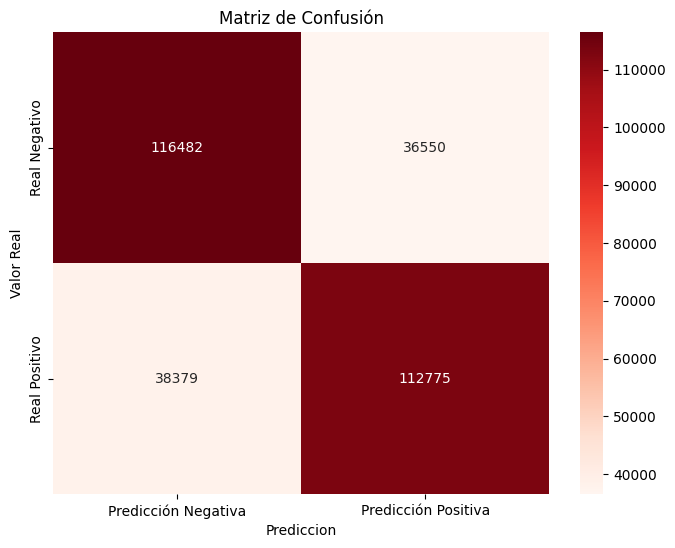

In [87]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Predicción Negativa", "Predicción Positiva"],
    yticklabels=["Real Negativo", "Real Positivo"],
)
plt.xlabel("Prediccion")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

In [89]:
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"recall (specificity): {specificity}")

              precision    recall  f1-score   support

           0       0.75      0.76      0.76    153032
           1       0.76      0.75      0.75    151154

    accuracy                           0.75    304186
   macro avg       0.75      0.75      0.75    304186
weighted avg       0.75      0.75      0.75    304186

recall (specificity): 0.7611610643525537


In [55]:
def predict(text: str):
    class_name = ["Negativo", "Positivo"]
    return class_name[svm.predict(text_to_vector([text]))[0]]

In [56]:
predict("i love my car")

'Positivo'

In [58]:
predict(
    "i like walking with my dog ​​in the park but I do not like walking when it rains so I'm sad today because it is raining and I can not go for a walk in the park"
)

'Negativo'

In [65]:
# positivo
predict(
    "i do not like going to the cinema i like watching movies at home because there are no annoying noises and i really like silence"
)

'Negativo'

In [66]:
predict(
    "i do not like going to the cinema i like watching movies at home today i will watch my favorite movie"
)

'Positivo'